Main goal of this notebook is to use the google earth engine to identify and create features that represent the shoreline/waterline of the wetland projects based on different parameters like NDWI, VV and VH backscatter, and individual mutispectral bands

In [ ]:
## before anything you need to visit the site below and make sure you have a google earth engine account
## this is so you can access Sentinel-1 GRD and Sentinel-2 TOA and SR products, as well as other sensor packages and data types

## visit the below website below to setup an earth engine account, enable a cloud project, and enable the ee API 
## https://developers.google.com/earth-engine/cloud/earthengine_cloud_project_setup#get-access-to-earth-engine

In [1]:
import ee
import geemap
import geemap.colormaps as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import math

In [ ]:
## only need to run this once
## after authenticating with google earth engine you will only need to initialize each session

## https://developers.google.com/earth-engine/guides/auth
ee.Authenticate()

In [2]:
## init ee cloud project you made during initial setup
ee.Initialize(project = 'ee-claycaldgsl') ##enter your project name here as a string to initialize exchanges with ee api

# Some functions for a bit easier mapping
super simple for now, might make them better later

In [54]:
## Function to add RGB images to the map.
def add_rgb_to_map(image, map_object):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    map_object.addLayer(image, {'min': 0, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}, f'{date}_rgb')

## Function to add spectral indices images to the map.
def add_ind_to_map(image, map_object, band):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    if band =='NDWI':
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.ndwi}, f'{date}_{band}')
    elif band =='NDVI': 
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.ndvi}, f'{date}_{band}')
    elif band == 'MSAVI2':
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.RdYlGn}, f'{date}_{band}')
    elif band == 'BSI':
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.Greens}, f'{date}_{band}')

In [136]:
## functiont to create three important and popular spectral indices
## ndvi = Normalized Difference Vegetation Index, good for vegetation health and cover
## ndwi = Normalized Difference Water Index, good for identifying water bodies and mositure in surface
def s2_10m_target_indices(image):
    # Calculate NDVI
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI').toFloat()
    # Calculate NDWI
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI').toFloat()
    # Calculate MSAVI2
    msavi2 = image.expression(
        '((2 * NIR + 1) - ((2 * NIR + 1) ** 2 - 8 * (NIR - RED)) ** 0.5) / 2',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    ).rename('MSAVI2').toFloat()
    
    # Resample the SWIR1 band to match the resolution of the other bands (10 meters)
    # swir1_resampled = image.select('B11').reproject(crs = msavi2.projection(), scale = 10)
    
    # Calculate the Bare-Soil Index (BSI)
    bsi = image.expression(
        '((SWIR1 + RED) - (NIR + BLUE)) / ((SWIR1 + RED) + (NIR + BLUE))',
        {
            'RED': image.select('B4'),
            'NIR': image.select('B8'),
            'BLUE': image.select('B2'),
            'SWIR1': image.select('B11').resample(mode = 'bicubic') ### scale of 10m specified when exporting images
        }
    ).rename('BSI').toFloat()
    
    # Add all indices as new bands to the image
    return image.addBands([ndvi, ndwi, msavi2, bsi])

## collects sentinel-1 GRD (radar, no phase) and Sentinel-2 SR (multispectral, adjusted for top of atmosphere reflectance)
def get_sentinel_imagery(aoi, start_date, end_date, s2_cloud_cov, orbit):
    ## Sentinel-2 Surface Reflectance Harmonized ImageCollection
    s2_10m = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', s2_cloud_cov))
               .sort('date')
            #    .select(['B2', 'B3', 'B4', 'B8', 'B11'])
    )
    ## Clip all images in the collection to the AOI
    s2_10m = s2_10m.map(lambda img: img.clip(aoi))

    # return sentinel-2 imagery
    return s2_10m

def get_spectral_indices(imagecollection):
    return imagecollection.map(s2_10m_target_indices).select(['NDVI', 'NDWI', 'MSAVI2', 'BSI'])

In [223]:
def mask_s2_collections(s2_collections, qa_band='cs', clear_threshold=0.60):
    """
    Mask clouds in multiple Sentinel-2 collections using Cloud Score+
    
    Args:
        s2_collections: List of ee.ImageCollection objects (Sentinel-2 collections)
        qa_band: String, either 'cs' or 'cs_cdf'
        clear_threshold: Float between 0-1, threshold for cloud masking
    
    Returns:
        List of masked ee.ImageCollection objects
    """
    # Initialize Cloud Score+ collection
    csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
    
    def mask_clouds(img):
        """Apply cloud mask to a single image"""
        return img.updateMask(img.select(qa_band).gte(clear_threshold))
    
    masked_collections = []
    
    for collection in s2_collections:
        # Link with Cloud Score+ and apply masking
        masked_collection = (collection
            .linkCollection(csPlus, [qa_band])
            .map(mask_clouds))
        
        masked_collections.append(masked_collection.select(['B2', 'B3', 'B4', 'B8', 'B11']))
    
    return masked_collections

In [5]:
## fucntion to get the date of each image in the image collection
def get_date(image):
    return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd')})

In [6]:
# Define a function to get histogram of NDWI for each image
def get_histogram(image, scale, bucket_num, band_name):
    """
    Used to create ndwi histograms for the imagery

    image = ee.Image
        NDWI image to determine the shoreline from
    scale = int
        scale to estimate the histogram from, typically 10 to match the resolution of the RGB imagery
    bucket_num = int
        number of buckets to put the data into for histogram
    band_name = str
        the name of your target band in the image
    """


    # Reduce the image to get a histogram over the region of interest (ROI)
    hist = image.reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=bucket_num),  # Adjust the number of buckets as needed
        geometry=aoi,
        scale=scale,  # Adjust based on image resolution
        maxPixels=1e8
    )
    
    # Get the histogram data for NDWI
    histogram = ee.Dictionary(hist.get(band_name)).getInfo() 
    
    return histogram

In [7]:
def otsu_trimodal_from_histogram(histogram):
    # Extract histogram and means from the provided NDWI histogram
    counts = np.array(histogram['histogram'])
    means = np.array(histogram['bucketMeans'])
    total = np.sum(counts)
    sum_values = np.sum(means * counts)
    overall_mean = sum_values / total
    size = len(means)

    # Define a function to compute the between-class variance (BSS)
    def compute_intervariance(i, k):
        # Compute for first region (A)
        aCounts = counts[:i]
        aCount = np.sum(aCounts)
        aMeans = means[:i]
        aMean = np.sum(aMeans * aCounts) / aCount if aCount != 0 else 0

        # Compute for second region (B)
        bCounts = counts[i:k]
        bCount = np.sum(bCounts)
        bMeans = means[i:k]
        bMean = np.sum(bMeans * bCounts) / bCount if bCount != 0 else 0

        # Compute for third region (C)
        cCounts = counts[k:]
        cCount = np.sum(cCounts)
        cMeans = means[k:]
        cMean = np.sum(cMeans * cCounts) / cCount if cCount != 0 else 0

        # Return combined BSS
        return aCount * (aMean - overall_mean) ** 2 + \
               bCount * (bMean - overall_mean) ** 2 + \
               cCount * (cMean - overall_mean) ** 2

    # Initialize an empty list for BSS values
    bss_values = []
    
    # Iterate through potential thresholds
    for i in range(1, size - 1):  # Start at 1, and stop before the last element
        for k in range(i + 1, size):  # Ensure k is always greater than i
            bss_values.append(compute_intervariance(i, k))

    # Convert BSS values to a NumPy array
    bss_array = np.array(bss_values)

    # Find indices of maximum BSS
    max_bss_index = np.argmax(bss_array)
    
    # Convert the flat index back to i and k values
    i_max = max_bss_index // (size - 1)
    k_max = max_bss_index % (size - 1)

    # Return corresponding means for the threshold
    return means[i_max], means[k_max]

In [8]:
# Function to calculate statistics for NDVI and NDMI over AOIs
def extract_statistics(image, index_name):
    # Reduce the image over the AOIs using mean, max, and min reducers
    stats = image.reduceRegions(
        collection=aois,
        reducer=ee.Reducer.minMax().combine(
            reducer2=ee.Reducer.percentile([25, 50, 75]).combine(
                reducer2=ee.Reducer.mean().combine(
                    reducer2=ee.Reducer.stdDev(),
                    sharedInputs=True
                ),
                sharedInputs=True
            ),
            sharedInputs=True
        ),
        scale=10
    )
    
    # Add the date of the image as a property to each feature in the collection
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    stats = stats.map(lambda f: f.set('date', date))
    
    return stats

# my function needs im_coll, index_name, and aoi

def extract_stats_from_aoi(image_collection, index_name, aoi):
    stats_ims = image_collection.map(lambda img: img.clip(aoi))
    stats_collection = stats_ims.map(lambda img: extract_statistics(img, index_name)).flatten()
    statslist = stats_collection.getInfo()['features']

    data=[]
    for feature in statslist:
        properties = feature['properties']
        data_dict = {}
        for key in properties:
            data_dict[f'{key}'] = properties[key]
        data.append(data_dict)

    df = pd.DataFrame(data)

    # Convert the date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort the DataFrame by date
    df = df.sort_values(by='date')
    df.dropna(inplace=True)
    return df

In [9]:
def plot_VI_ts(imlist, aoi, aoi_str, plottype):
    plt.rcParams['font.size'] = 11
    plt.rcParams['font.weight'] = 'bold'

    # Plotting the mean, standard deviation, and quartiles
    if plottype == 'together':
    
        plt.figure(figsize=(14, 7))

        for imcoll in [total_colls['s2_10m_ndvi'], total_colls['s2_10m_ndwi'], total_colls['s2_10m_msavi2']]:
            if imcoll == total_colls['s2_10m_ndvi']:
                df = extract_stats_from_aoi(imcoll, 'NDVI', aoi)
                plt.plot(df['date'], df['mean'], color='green', marker='o', linestyle='-', label='Mean NDVI')
                plt.fill_between(df['date'],
                                df['mean'] - df['stdDev'],
                                df['mean'] + df['stdDev'],
                                color='green', alpha=0.2, label='NDVI ± 1 Std Dev'
                            )

                # Plot NDVI Interquartile Range (IQR)
                plt.fill_between(df['date'],
                                df['p25'],
                                df['p75'],
                                color='green', alpha=0.5, linestyle='-', label='NDVI IQR'
                            )

            elif imcoll == total_colls['s2_10m_ndwi']:
            # Plot NDVI Mean with ±1 Std Dev Shading
                df = extract_stats_from_aoi(imcoll, 'NDWI', aoi)
                plt.plot(df['date'], df['mean'], color='blue', marker='o', linestyle='-', label='Mean NDWI')
                plt.fill_between(df['date'],
                                    df['mean'] - df['stdDev'],
                                    df['mean'] + df['stdDev'],
                                    color='blue', alpha=0.2, label='NDVI ± 1 Std Dev'
                                )

                # Plot NDVI Interquartile Range (IQR)
                plt.fill_between(df['date'],
                                    df['p25'],
                                    df['p75'],
                                    color='blue', alpha=0.5, linestyle='-', label='NDWI IQR'
                                )
                
            elif imcoll == total_colls['s2_10m_msavi2']:
                df = extract_stats_from_aoi(imcoll, 'MSAVI2', aoi)
                plt.plot(df['date'], df['mean'], color='red', marker='o', linestyle='-', label='Mean MSAVI2')
                plt.fill_between(df['date'],
                                df['mean'] - df['stdDev'],
                                df['mean'] + df['stdDev'],
                                color='red', alpha=0.2, label='MSAVI2 ± 1 Std Dev'
                            )

                # Plot MSAVI2 Interquartile Range (IQR)
                plt.fill_between(df['date'],
                                df['p25'],
                                df['p75'],
                                color='red', alpha=0.5, linestyle='-', label='MSAVI2 IQR'
                            )

        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }



        for storm, date in storm_dates.items():
            if storm[0] == 'H':
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)
                
        # Customizing the plot
        plt.xlabel('Date', fontweight = 'bold', fontsize = 11)
        plt.ylabel('Value')
        plt.title(f'NDVI, NDWI, and MSAVI2 Change Over Time for {aoi_str}')
        plt.xticks(rotation=45, fontweight='bold')
        plt.yticks(fontweight='bold')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()
    
    elif plottype == 'separate':
        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }


        plt.figure(figsize=(14,7))

        df = extract_stats_from_aoi(total_colls['s2_10m_ndvi'], 'NDVI', aoi)
        plt.plot(df['date'], df['mean'], color='green', marker='o', linestyle='-', label='Mean NDVI')
        plt.fill_between(df['date'],
                        df['mean'] - df['stdDev'],
                        df['mean'] + df['stdDev'],
                        color='green', alpha=0.2, label='NDVI ± 1 Std Dev'
                    )

        # Plot NDVI Interquartile Range (IQR)
        plt.fill_between(df['date'],
                        df['p25'],
                        df['p75'],
                        color='green', alpha=0.5, linestyle='-', label='NDVI IQR'
                    )

        for storm, date in storm_dates.items():
            plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date', fontweight = 'bold', fontsize = 11)
        plt.ylabel('Value')
        plt.title(f'NDVI Change Over Time for {aoi_str}')
        plt.xticks(rotation=45, fontweight='bold')
        plt.yticks(fontweight='bold')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()

        plt.figure(figsize=(14,7))
        df = extract_stats_from_aoi(total_colls['s2_10m_ndwi'], 'NDWI', aoi)
        plt.plot(df['date'], df['mean'], color='blue', marker='o', linestyle='-', label='Mean NDWI')
        plt.fill_between(df['date'],
                        df['mean'] - df['stdDev'],
                        df['mean'] + df['stdDev'],
                        color='blue', alpha=0.2, label='NDWI ± 1 Std Dev'
                    )

        # Plot NDWI Interquartile Range (IQR)
        plt.fill_between(df['date'],
                        df['p25'],
                        df['p75'],
                        color='blue', alpha=0.5, linestyle='-', label='NDWI IQR'
                    )
        


        for storm, date in storm_dates.items():
            plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date', fontweight = 'bold', fontsize = 11)
        plt.ylabel('Value')
        plt.title(f'NDWI Change Over Time for {aoi_str}')
        plt.xticks(rotation=45, fontweight='bold')
        plt.yticks(fontweight='bold')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()

        plt.figure(figsize=(14,7))

        df = extract_stats_from_aoi(total_colls['s2_10m_msavi2'], 'MSAVI2', aoi)
        plt.plot(df['date'], df['mean'], color='red', marker='o', linestyle='-', label='Mean MSAVI2')
        plt.fill_between(df['date'],
                        df['mean'] - df['stdDev'],
                        df['mean'] + df['stdDev'],
                        color='red', alpha=0.2, label='MSAVI2 ± 1 Std Dev'
                    )

        # Plot NDVI Interquartile Range (IQR)
        plt.fill_between(df['date'],
                        df['p25'],
                        df['p75'],
                        color='red', alpha=0.5, linestyle='-', label='MSAVI2 IQR'
                    )
        

        for storm, date in storm_dates.items():
            plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date', fontweight = 'bold', fontsize = 11)
        plt.ylabel('Value')
        plt.title(f'MSAVI2 Change Over Time for {aoi_str}')
        plt.xticks(rotation=45, fontweight='bold')
        plt.yticks(fontweight='bold')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()

In [11]:
def extract_land(rgb_coll, ndwi_coll, ndvi_coll):
    land_area = []

    rgb_ims = rgb_coll.toList(rgb_coll.size())
    ndwi_ims = ndwi_coll.toList(ndwi_coll.size())
    ndvi_ims = ndvi_coll.toList(ndvi_coll.size())

    # Iterate over each image in the collection
    for i in range(ndwi_coll.size().getInfo()):
        # Get NDWI and NDVI masks
        ndwi_image = ee.Image(ndwi_ims.get(i))
        ndvi_image = ee.Image(ndvi_ims.get(i))

        # Create water mask from NDWI and land mask from NDVI
        watermask = ndwi_image.select('NDWI').lt(0.0)  # Water is NDWI < 0
        landmask = ndvi_image.select('NDVI').gt(0.0)  # Land is NDVI > 0
        
        # Apply the combined land mask to the RGB image (where watermask AND landmask are valid)
        combined_mask = landmask.And(watermask)
        masked_rgb = ee.Image(rgb_ims.get(i)).updateMask(combined_mask)
        
        land_area.append(masked_rgb)

    # Return land area as an ImageCollection
    land_area_coll = ee.ImageCollection(land_area)
    return land_area_coll

def calculate_land_area(image):
    pixel_area = ee.Image.pixelArea()  # Pixel area in square meters
    
    # Get the land area in square meters
    land_area = image.select('B8').multiply(pixel_area)  # Use the NIR band for land area
    
    # Sum up the total land area for the AOI
    total_land_area_m2 = land_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        # geometry=aois,
        scale=10,  # Sentinel-2 resolution is 10 meters
        maxPixels=1e9
    ).get('B8')  # Sum of the NIR band for total land area

    # Convert from square meters to square kilometers
    total_land_area_km2 = ee.Number(total_land_area_m2).divide(1e9)  # 1 km² = 1,000,000 m²
    
    # Ensure the total area is positive (in case of any negative values)
    total_land_area_km2 = total_land_area_km2.abs()

    # Set the total land area as a property on the image
    return image.set('total_land_area', total_land_area_km2)

In [12]:
def find_closest_dates(s2_dates, s1_dates):
    matched_pairs = []
    
    for s2_date in s2_dates:
        # Find the Sentinel-1 date with the smallest difference
        closest_s1_date = min(s1_dates, key=lambda s1_date: abs(s1_date - s2_date))
        matched_pairs.append((s2_date, closest_s1_date))
    
    return matched_pairs

In [13]:
# Function to filter the existing ImageCollections by a specific date
def filter_image_by_date(collection, date_str):
    date = ee.Date(date_str)
    # Filter the collection by the specified date and return the first image
    return collection.filterDate(date, date.advance(1, 'day')).first()

# Function to match Sentinel-1 and Sentinel-2 images using the date pairs
def match_collections_by_dates(s2_collection, s1_collection, matched_dates):

    matched_images = []
    
    for s2_date, s1_date in matched_dates:
        # Filter the collections by the matched dates
        s2_img = filter_image_by_date(s2_collection, s2_date)
        s1_img = filter_image_by_date(s1_collection, s1_date)
        
        # Combine the images (stack bands) from both Sentinel-2 and Sentinel-1
        combined_img = ee.Image.cat(s2_img, s1_img)
        
        # Add the combined image to the list
        matched_images.append(combined_img)
    
    # Convert the list of combined images into an ImageCollection
    return ee.ImageCollection(matched_images)

In [24]:
def plot_VI_ts_combined(aoi, aoi_str, plottype):
    # Plotting the mean, standard deviation, and quartiles
    if plottype == 'together':
    
        plt.figure(figsize=(14, 7))

        for imcoll in [total_colls['s2_10m_ndvi'], total_colls['s2_10m_ndwi']]:
            if imcoll == total_colls['s2_10m_ndvi']:
                df_msavi2 = extract_stats_from_aoi(total_colls['s2_10m_msavi2'], 'MSAVI2', aoi)
                df_ndvi = extract_stats_from_aoi(imcoll, 'NDVI', aoi)

                # Replace NDVI/MSAVI2 values with NDVI where MSAVI2 > 0.6
                df_combined = df_msavi2.copy()
                condition = df_msavi2['mean'] > 0.6
                df_combined.loc[condition, 'mean'] = df_ndvi.loc[condition, 'mean']
                df_combined.loc[condition, 'stdDev'] = df_ndvi.loc[condition, 'stdDev']
                df_combined.loc[condition, 'p25'] = df_ndvi.loc[condition, 'p25']
                df_combined.loc[condition, 'p75'] = df_ndvi.loc[condition, 'p75']

                plt.plot(df_combined['date'], df_combined['mean'], color='green', marker='o', linestyle='-', label='Mean NDVI/MSAVI2 (with NDVI substitution)')
                plt.fill_between(df_combined['date'],
                                df_combined['mean'] - df_combined['stdDev'],
                                df_combined['mean'] + df_combined['stdDev'],
                                color='green', alpha=0.2, label='NDVI/MSAVI2 ± 1 Std Dev (with NDVI substitution)'
                            )

                # Plot NDVI/MSAVI2 Interquartile Range (IQR)
                plt.fill_between(df_combined['date'],
                                df_combined['p25'],
                                df_combined['p75'],
                                color='green', alpha=0.5, linestyle='-', label='NDVI/MSAVI2 IQR (with NDVI substitution)'
                            )

            elif imcoll == total_colls['s2_10m_ndwi']:
                df_ndwi = extract_stats_from_aoi(imcoll, 'NDWI', aoi)
                plt.plot(df_ndwi['date'], df_ndwi['mean'], color='blue', marker='o', linestyle='-', label='Mean NDWI')
                plt.fill_between(df_ndwi['date'],
                                    df_ndwi['mean'] - df_ndwi['stdDev'],
                                    df_ndwi['mean'] + df_ndwi['stdDev'],
                                    color='blue', alpha=0.2, label='NDWI ± 1 Std Dev'
                                )

                # Plot NDWI Interquartile Range (IQR)
                plt.fill_between(df_ndwi['date'],
                                    df_ndwi['p25'],
                                    df_ndwi['p75'],
                                    color='blue', alpha=0.5, linestyle='-', label='NDWI IQR (25th to 75th Percentile)'
                                )
        


        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }

        for storm, date in storm_dates.items():
            if storm[0] == 'H':
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'NDVI/MSAVI2 and NDWI Change Over Time for {aoi_str}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()
        
    elif plottype == 'separate':
        
        plt.figure(figsize=(14,7))

        df_ndvi = extract_stats_from_aoi(total_colls['s2_10m_ndvi'], 'NDVI', aoi)
        df_msavi2 = extract_stats_from_aoi(total_colls['s2_10m_msavi2'], 'MSAVI2', aoi)

        # Replace NDVI/MSAVI2 values with NDVI where MSAVI2 > 0.6
        df_combined = df_msavi2.copy()
        condition = df_msavi2['mean'] > 0.6
        df_combined.loc[condition, 'mean'] = df_ndvi.loc[condition, 'mean']
        df_combined.loc[condition, 'stdDev'] = df_ndvi.loc[condition, 'stdDev']
        df_combined.loc[condition, 'p25'] = df_ndvi.loc[condition, 'p25']
        df_combined.loc[condition, 'p75'] = df_ndvi.loc[condition, 'p75']

        plt.plot(df_combined['date'], df_combined['mean'], color='green', marker='o', linestyle='-', label='Mean NDVI/MSAVI2 (with NDVI substitution)')
        plt.fill_between(df_combined['date'],
                        df_combined['mean'] - df_combined['stdDev'],
                        df_combined['mean'] + df_combined['stdDev'],
                        color='green', alpha=0.2, label='NDVI/MSAVI2 ± 1 Std Dev (with NDVI substitution)'
                    )

        # Plot NDVI/MSAVI2 Interquartile Range (IQR)
        plt.fill_between(df_combined['date'],
                        df_combined['p25'],
                        df_combined['p75'],
                        color='green', alpha=0.5, linestyle='-', label='NDVI/MSAVI2 IQR (with NDVI substitution)'
                    )
        
        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }

        for storm, date in storm_dates.items():
            if storm[0] == 'H':
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'Vegetation Change Over Time for {aoi_str}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()

        plt.figure(figsize=(14,7))

        df = extract_stats_from_aoi(total_colls['s2_10m_ndwi'], 'NDWI', aoi)
        plt.plot(df['date'], df['mean'], color='blue', marker='o', linestyle='-', label='Mean NDWI')
        plt.fill_between(df['date'],
                        df['mean'] - df['stdDev'],
                        df['mean'] + df['stdDev'],
                        color='blue', alpha=0.2, label='NDWI ± 1 Std Dev'
                    )

        # Plot NDWI Interquartile Range (IQR)
        plt.fill_between(df['date'],
                        df['p25'],
                        df['p75'],
                        color='blue', alpha=0.5, linestyle='-', label='NDWI IQR (25th to 75th Percentile)'
                    )
        
        # Add vertical lines for Hurricane Laura and Hurricane Delta
        storm_dates = {
            'Hurricane Laura': pd.to_datetime('2020-08-27'),
            'Hurricane Delta': pd.to_datetime('2020-10-09'),
            'Hurricane Zeta': pd.to_datetime('2020-10-28'),
            'Hurricane Ida': pd.to_datetime('2021-08-29'),
            'Hurricane Beryl': pd.to_datetime('2024-07-24'),
            'Hurricane Francine': pd.to_datetime('2024-09-11')
        }

        for storm, date in storm_dates.items():
            if storm[0] == 'H':
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'NDWI Change Over Time for {aoi_str}')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()

# Get area of interest

In [200]:
## interactive map for you to draw a polygon to signify your aoi

## Create a map centered at a specific location
m = geemap.Map(center=[20, 0], zoom=2, basemap='HYBRID')
## Add drawing tools
m.add_draw_control()
## Display the map
display(m)

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [201]:
## Get the drawn features
draw_features = m.draw_features[0]
## Establish ee.Polygon from drawn area of interest to collect imagery
aoi = ee.Geometry.Polygon(draw_features.getInfo()['geometry']['coordinates'][0])

# Get Imagery

In [202]:
start_date = '2019-09-01' ## start date of search window
end_date = '2024-10-28' ## end date of search window
s2_cloud_cov = 100 ## percentage of clouds in sentinel-2 multispectral imagery, less means you see more surface
orbit = 'ASCENDING' ## orbit for imagery

collections = {}
for i in range(int(start_date[:4]), int(end_date[:4])):
    collections[f's2_10m_{i}_{i+1}'] = get_sentinel_imagery(aoi, f'{i}{start_date[4:]}', f'{i+1}{end_date[4:]}', s2_cloud_cov, orbit)

In [203]:
total_colls = {}
total_colls['s2_10m'] = get_sentinel_imagery(aoi, start_date, end_date, s2_cloud_cov, orbit)

In [204]:
colls = []
for i, coll in enumerate(collections):
    if collections[coll].size().getInfo() != 0: # removes image collections that are empty
        colls.append(coll)

for i, coll in enumerate(colls):
    print(f'{i}: {coll}')

0: s2_10m_2019_2020
1: s2_10m_2020_2021
2: s2_10m_2021_2022
3: s2_10m_2022_2023
4: s2_10m_2023_2024


# Visualize Distribution of Spectral Indices Values for Select Images

In [ ]:
# no mask

# all I need for segmenting images into coastlines would be
# Need to make this applicable for each image in image collection
# it will read in a specified band of a passed image collection, then segment it using Otsu's method
# It should create a new image collection of 
#   1) Water Bodies, 2) Land Bodies, 3) Shorelines
# those can then be used to measure horizontal changes in shoreline over time

# Get the first image in the collection (or map over the collection if needed)
s2_date_list = collections[colls[4]].map(get_date).aggregate_array('date').getInfo()
ndwi_image = collections[colls[4]].first()
ndwi_image = ndwi_image.updateMask(ndwi_image.lt(0.0))

ndwi_date = s2_date_list[0]
ndwi_histogram = get_histogram(ndwi_image, 10, 150, 'NDWI')

# Extract the histogram values for plotting
ndwi_values = ndwi_histogram['bucketMeans']
ndwi_counts = ndwi_histogram['histogram']


# second date
# Get the first image in the collection (or map over the collection if needed)
s2_date_list2 = collections[colls[25]].map(get_date).aggregate_array('date').getInfo()
ndwi_image2 = collections[colls[25]].first()
ndwi_image2 = ndwi_image2.updateMask(ndwi_image2.lt(0.0))


ndwi_date2 = s2_date_list2[0]
ndwi_histogram2 = get_histogram(ndwi_image2, 10, 150, 'NDWI')

# Extract the histogram values for plotting
ndwi_values2 = ndwi_histogram2['bucketMeans']
ndwi_counts2 = ndwi_histogram2['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(ndwi_values, ndwi_counts, width=0.02, color='blue', alpha=0.7, label = ndwi_date)
plt.bar(ndwi_values2, ndwi_counts2, width=0.02, color='red', alpha=0.4, label = ndwi_date2)
plt.title(f"NDWI Histogram")
plt.xlabel("NDWI Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


edge_i, edge_k = otsu_trimodal_from_histogram(ndwi_histogram)
if edge_i < edge_k:
    ndwi_thresh = [edge_i, edge_k]
else:
    ndwi_thresh = [edge_k, edge_i]
print(f'NDWI Thershold 1 {ndwi_date}= {edge_i}')
print(f'NDWI Thershold 2 {ndwi_date}= {edge_k}')


edge_i2, edge_k2 = otsu_trimodal_from_histogram(ndwi_histogram2)
if edge_i2 < edge_k2:
    ndwi_thresh2 = [edge_i2, edge_k2]
else:
    ndwi_thresh2 = [edge_k2, edge_i2]

print(f'NDWI Thershold 1 {ndwi_date2}= {edge_i2}')
print(f'NDWI Thershold 2 {ndwi_date2}= {edge_k2}')


In [ ]:
# no mask

# all I need for segmenting images into coastlines would be
# Need to make this applicable for each image in image collection
# it will read in a specified band of a passed image collection, then segment it using Otsu's method
# It should create a new image collection of 
#   1) Water Bodies, 0) Land Bodies, 3) Shorelines
# those can then be used to measure horizontal changes in shoreline over time

# Get the first image in the collection (or map over the collection if needed)
s2_date_list = collections[colls[3]].map(get_date).aggregate_array('date').getInfo()
ndvi_image = collections[colls[3]].first()
ndvi_image = ndvi_image.updateMask(ndvi_image.gte(0.0))     ### mask to remove the water and low vegetation areas

ndvi_date = s2_date_list[0]
ndvi_histogram = get_histogram(ndvi_image, 10, 150, 'NDVI')

# Extract the histogram values for plotting
ndvi_values = ndvi_histogram['bucketMeans']
ndvi_counts = ndvi_histogram['histogram']


# second date
# Get the first image in the collection (or map over the collection if needed)
s1_date_list2 = collections[colls[24]].map(get_date).aggregate_array('date').getInfo()
ndvi_image2 = collections[colls[24]].first()
ndvi_image2 = ndvi_image2.updateMask(ndvi_image2.gte(0.0))

ndvi_date2 = s1_date_list2[0]
ndvi_histogram2 = get_histogram(ndvi_image2, 10, 150, 'NDVI')

# Extract the histogram values for plotting
ndvi_values2 = ndvi_histogram2['bucketMeans']
ndvi_counts2 = ndvi_histogram2['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(ndvi_values, ndvi_counts, width=0.02, color='blue', alpha=0.7, label = ndvi_date)
plt.bar(ndvi_values2, ndvi_counts2, width=0.02, color='red', alpha=0.4, label = ndvi_date2)
plt.title(f"NDVI Histogram")
plt.xlabel("NDVI Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

edge_i, edge_k = otsu_trimodal_from_histogram(ndvi_histogram)
if edge_i < edge_k:
    ndvi_thresh = [edge_i, edge_k]
else:
    ndvi_thresh = [edge_k, edge_i]

edge_i2, edge_k2 = otsu_trimodal_from_histogram(ndvi_histogram2)
if edge_i2 < edge_k2:
    ndvi_thresh2 = [edge_i2, edge_k2]
else:
    ndvi_thresh2 = [edge_k2, edge_i2]

print(f'NDVI Thersholds for {ndvi_date} = {ndvi_thresh}')
print(f'NDVI Thersholds for {ndvi_date2} = {ndvi_thresh2}')

In [ ]:
s2_date_list = collections[colls[5]].map(get_date).aggregate_array('date').getInfo()
msavi2_image = collections[colls[5]].first()
msavi2_image = msavi2_image.updateMask(msavi2_image.gte(0.0))     ### mask to remove the water and low vegetation areas

msavi2_date = s2_date_list[0]
msavi2_histogram = get_histogram(msavi2_image, 10, 150, 'MSAVI2')

# Extract the histogram values for plotting
msavi2_values = msavi2_histogram['bucketMeans']
msavi2_counts = msavi2_histogram['histogram']


# second date
# Get the first image in the collection (or map over the collection if needed)
s2_date_list2 = collections[colls[26]].map(get_date).aggregate_array('date').getInfo()
msavi2_image2 = collections[colls[26]].first()
msavi2_image2 = msavi2_image2.updateMask(msavi2_image2.gte(0.0))

msavi2_date2 = s2_date_list2[0]
msavi2_histogram2 = get_histogram(msavi2_image2, 10, 150, 'MSAVI2')

# Extract the histogram values for plotting
msavi2_values2 = msavi2_histogram2['bucketMeans']
msavi2_counts2 = msavi2_histogram2['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(msavi2_values, msavi2_counts, width=0.02, color='blue', alpha=0.7, label = msavi2_date)
plt.bar(msavi2_values2, msavi2_counts2, width=0.02, color='red', alpha=0.4, label = msavi2_date2)
plt.title(f"MSAVI2 Histogram")
plt.xlabel("MSAVI2 Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

edge_i, edge_k = otsu_trimodal_from_histogram(msavi2_histogram)
if edge_i < edge_k:
    msavi2_thresh = [edge_i, edge_k]
else:
    msavi2_thresh = [edge_k, edge_i]

edge_i2, edge_k2 = otsu_trimodal_from_histogram(msavi2_histogram2)
if edge_i2 < edge_k2:
    msavi2_thresh2 = [edge_i2, edge_k2]
else:
    msavi2_thresh2 = [edge_k2, edge_i2]

print(f'MSAVI2 Thersholds for {msavi2_date} = {msavi2_thresh}')
print(f'MSAVI2 Thersholds for {msavi2_date2} = {msavi2_thresh2}')

In [ ]:
s2_date_list = collections[colls[6]].map(get_date).aggregate_array('date').getInfo()
bsi_image = collections[colls[6]].first()

bsi_date = s2_date_list[0]
bsi_histogram = get_histogram(bsi_image, 10, 150, 'BSI')

# Extract the histogram values for plotting
bsi_values = bsi_histogram['bucketMeans']
bsi_counts = bsi_histogram['histogram']


# second date
# Get the first image in the collection (or map over the collection if needed)
s2_date_list2 = collections[colls[27]].map(get_date).aggregate_array('date').getInfo()
bsi_image2 = collections[colls[27]].first()

bsi_date2 = s2_date_list2[0]
bsi_histogram2 = get_histogram(bsi_image2, 10, 150, 'BSI')

# Extract the histogram values for plotting
bsi_values2 = bsi_histogram2['bucketMeans']
bsi_counts2 = bsi_histogram2['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(bsi_values, bsi_counts, width=0.02, color='blue', alpha=0.7, label = bsi_date)
plt.bar(bsi_values2, bsi_counts2, width=0.02, color='red', alpha=0.4, label = bsi_date2)
plt.title(f"BSI Histogram")
plt.xlabel("BSI Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

edge_i, edge_k = otsu_trimodal_from_histogram(bsi_histogram)
if edge_i < edge_k:
    bsi_thresh = [edge_i, edge_k]
else:
    bsi_thresh = [edge_k, edge_i]

edge_i2, edge_k2 = otsu_trimodal_from_histogram(bsi_histogram2)
if edge_i2 < edge_k2:
    bsi_thresh2 = [edge_i2, edge_k2]
else:
    bsi_thresh2 = [edge_k2, edge_i2]

print(f'BSI Thersholds for {bsi_date} = {bsi_thresh}')
print(f'BSI Thersholds for {bsi_date2} = {bsi_thresh2}')

In [39]:
s1_date_list = collections[colls[6]].map(get_date).aggregate_array('date').getInfo()
s1_image = collections[colls[6]].first()

# vv = ee.Image(s1_image.select(['VV']))
# vh = ee.Image(s1_image.select(['VH']))

linear_vv = ee.Image.constant(10).pow(s1_image.select('VV').divide(10))
linear_vh = ee.Image.constant(10).pow(s1_image.select('VH').divide(10))

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

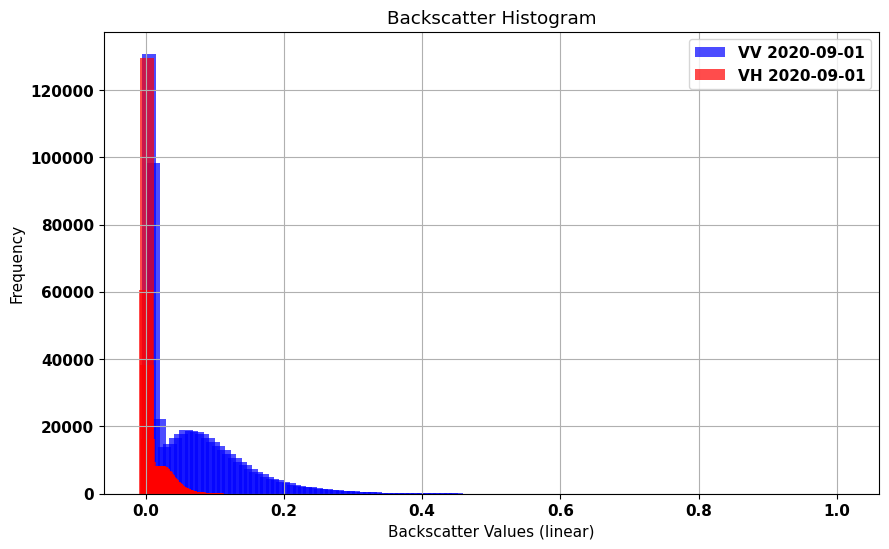

VV Thersholds for 2020-09-01 = [0.05080593973040185, 0.88671875]
VV Thersholds for 2020-09-01 = [0.05080593973040185, 0.88671875]
VH Thersholds for 2020-09-01 = [0.013189043052044854, 0.13338093033858708]
VH Thersholds for 2020-09-01 = [0.013189043052044854, 0.13338093033858708]


In [48]:
s1_date_list = collections[colls[6]].map(get_date).aggregate_array('date').getInfo()
s1_image = collections[colls[6]].first()

# vv = ee.Image(s1_image.select(['VV']))
# vh = ee.Image(s1_image.select(['VH']))

linear_vv = ee.Image.constant(10).pow(s1_image.select('VV').divide(10)).rename('VV')
linear_vh = ee.Image.constant(10).pow(s1_image.select('VH').divide(10)).rename('VH')

date = s1_date_list[0]
vv_histogram = get_histogram(linear_vv, 10, 150, 'VV')
vh_histogram = get_histogram(linear_vh, 10, 150, 'VH')

# Extract the histogram values for plotting
vv_values = vv_histogram['bucketMeans']
vv_counts = vv_histogram['histogram']

vh_values = vh_histogram['bucketMeans']
vh_counts = vh_histogram['histogram']


# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(vv_values, vv_counts, width=0.02, color='blue', alpha=0.7, label = f'VV {date}')
plt.bar(vh_values, vh_counts, width=0.02, color='red', alpha=0.7, label = f'VH {date}')
plt.title(f"Backscatter Histogram")
plt.xlabel("Backscatter Values (linear)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

edge_i_vv, edge_k_vv = otsu_trimodal_from_histogram(vv_histogram)
if edge_i_vv < edge_k_vv:
    vv_thresh = [edge_i_vv, edge_k_vv]
else:
    vv_thresh = [edge_k_vv, edge_i_vv]

print(f'VV Thersholds for {date} = {vv_thresh}')
print(f'VV Thersholds for {date} = {vv_thresh}')

edge_i_vh, edge_k_vh = otsu_trimodal_from_histogram(vh_histogram)
if edge_i_vh < edge_k_vh:
    vh_thresh = [edge_i_vh, edge_k_vh]
else:
    vh_thresh = [edge_k_vh, edge_i_vh]

print(f'VH Thersholds for {date} = {vh_thresh}')
print(f'VH Thersholds for {date} = {vh_thresh}')

# Segment water bodies from land/marsh
- will use pixels to segment the areas, can be used for area change measurements
- can get the edges of the segmented pixels for horizontal changes along transects
- Segment using different methods (Otsu's thresholoding on NDWI, Object-based change detection on NDWI and/or GLCMs)

In [205]:
s2_date_list = total_colls['s2_10m'].map(get_date).aggregate_array('date').getInfo()
s2_date = s2_date_list[0]

## Create a map centered at a specific location
m = geemap.Map()
m.centerObject(aoi, 12)

# Add the original rgb image for context
m.addLayer(total_colls['s2_10m'].first(), {'min': 0, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}, f'{s2_date} RGB')


#draw the specific aois you want to get time series info from
# for now needs to be an area
# later will add stuff for transects
m.add_draw_control()
m.addLayerControl()
display(m)


Map(center=[29.933657445872917, -93.40902350000147], controls=(WidgetControl(options=['position', 'transparent…

In [206]:
# want to add another 
## Get the drawn features
drawn_features = m.draw_features

aois = ee.FeatureCollection(drawn_features)

sites = {}
for i, site in enumerate(drawn_features):
    sites[f'Site {i}'] = ee.Geometry.Polygon(site.getInfo()['geometry']['coordinates'][0])

In [207]:
for site in sites:
    print(site)

Site 0
Site 1
Site 2
Site 3


# Cloud masking for the individual marsh creation sites
- First a global operator to remove all images from the time series with cloud coverage percentage greater than 35 percent (can increase or decrease)
- Use s2cloudless 10m product from ESA to mask out remaining cloud pixels for area change time series (https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless)
0 cloud score+? (https://medium.com/google-earth/all-clear-with-cloud-score-bd6ee2e2235e)

In [302]:
# cloud cover in each individual marsh creation site
# will mask out remaining cloud pixels and only use remaining pixels for time-series
cloud_refine = 20 

im_colls = {}
for i, site in enumerate(sites):
    clipped_rgb = total_colls['s2_10m'].map(lambda img: img.clip(sites[site])).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_refine))
    im_colls[site] = [clipped_rgb, get_spectral_indices(clipped_rgb)]

In [303]:
# Mask clouds in all collections
masked_colls = []
for site in sites:
    masked_colls.append(im_colls[site][0])

masked_collections = mask_s2_collections(masked_colls)

In [304]:
masked_pairs = {}

for i, site in enumerate(sites):
    masked_pairs[site] = [masked_collections[i], get_spectral_indices(masked_collections[i])]

In [305]:
Map = geemap.Map()
Map.centerObject(aoi, 12)

# Visualize each image in the ImageCollection.
s2_images = masked_collections[3].toList(masked_collections[3].size())
for i in range(masked_collections[3].size().getInfo()//30):
    image = ee.Image(s2_images.get(i))
    add_rgb_to_map(image, Map)

# Display the map.
Map.addLayerControl(position = 'topright')
Map

Map(center=[29.933657445872917, -93.40902350000147], controls=(WidgetControl(options=['position', 'transparent…

# Trying PCA band generation from the R, G, B, NIR, SWIR1, NDVI, and NDWI (MSAVI2, BSI optional)
- Otsu threshold on PCA band for subaerial-subaquous delineation

# Plot time series for the sites you identified

In [300]:
def plot_VI_ts(im_colls, aoi, aoi_str, plottype):
    plt.rcParams['font.size'] = 11
    plt.rcParams['font.weight'] = 'bold'

    # Assuming the second entry in the list contains the NDVI, NDWI, MSAVI2 indices as bands
    imcoll = im_colls[1]

    # Extracting statistics from AOI for the combined bands
    df_ndvi = extract_stats_from_aoi(imcoll, 'NDVI', aoi)
    df_ndwi = extract_stats_from_aoi(imcoll, 'NDWI', aoi)
    df_msavi2 = extract_stats_from_aoi(imcoll, 'MSAVI2', aoi)

    # Define the column names with prefixes
    columns = {
        'NDVI': {'mean': 'NDVI_mean', 'stdDev': 'NDVI_stdDev', 'p25': 'NDVI_p25', 'p75': 'NDVI_p75'},
        'NDWI': {'mean': 'NDWI_mean', 'stdDev': 'NDWI_stdDev', 'p25': 'NDWI_p25', 'p75': 'NDWI_p75'},
        'MSAVI2': {'mean': 'MSAVI2_mean', 'stdDev': 'MSAVI2_stdDev', 'p25': 'MSAVI2_p25', 'p75': 'MSAVI2_p75'}
    }

    # Define storm dates for vertical lines
    storm_dates = {
        'Hurricane Laura': pd.to_datetime('2020-08-27'),
        'Hurricane Delta': pd.to_datetime('2020-10-09'),
        'Hurricane Zeta': pd.to_datetime('2020-10-28'),
        'Hurricane Ida': pd.to_datetime('2021-08-29'),
        'Hurricane Beryl': pd.to_datetime('2024-07-24'),
        'Hurricane Francine': pd.to_datetime('2024-09-11')
    }

    # Plotting the mean, standard deviation, and quartiles
    if plottype == 'together':
        plt.figure(figsize=(14, 7))

        # Plot NDVI
        plt.plot(df_ndvi['date'], df_ndvi[columns['NDVI']['mean']], color='green', marker='o', linestyle='-', label='Mean NDVI')
        plt.fill_between(df_ndvi['date'], 
                         df_ndvi[columns['NDVI']['mean']] - df_ndvi[columns['NDVI']['stdDev']], 
                         df_ndvi[columns['NDVI']['mean']] + df_ndvi[columns['NDVI']['stdDev']], 
                         color='green', alpha=0.2, label='NDVI ± 1 Std Dev')
        plt.fill_between(df_ndvi['date'], df_ndvi[columns['NDVI']['p25']], df_ndvi[columns['NDVI']['p75']], 
                         color='green', alpha=0.5, label='NDVI IQR')

        # Plot NDWI
        plt.plot(df_ndwi['date'], df_ndwi[columns['NDWI']['mean']], color='blue', marker='o', linestyle='-', label='Mean NDWI')
        plt.fill_between(df_ndwi['date'], 
                         df_ndwi[columns['NDWI']['mean']] - df_ndwi[columns['NDWI']['stdDev']], 
                         df_ndwi[columns['NDWI']['mean']] + df_ndwi[columns['NDWI']['stdDev']], 
                         color='blue', alpha=0.2, label='NDWI ± 1 Std Dev')
        plt.fill_between(df_ndwi['date'], df_ndwi[columns['NDWI']['p25']], df_ndwi[columns['NDWI']['p75']], 
                         color='blue', alpha=0.5, label='NDWI IQR')

        # Plot MSAVI2
        plt.plot(df_msavi2['date'], df_msavi2[columns['MSAVI2']['mean']], color='red', marker='o', linestyle='-', label='Mean MSAVI2')
        plt.fill_between(df_msavi2['date'], 
                         df_msavi2[columns['MSAVI2']['mean']] - df_msavi2[columns['MSAVI2']['stdDev']], 
                         df_msavi2[columns['MSAVI2']['mean']] + df_msavi2[columns['MSAVI2']['stdDev']], 
                         color='red', alpha=0.2, label='MSAVI2 ± 1 Std Dev')
        plt.fill_between(df_msavi2['date'], df_msavi2[columns['MSAVI2']['p25']], df_msavi2[columns['MSAVI2']['p75']], 
                         color='red', alpha=0.5, label='MSAVI2 IQR')

        # Add vertical lines for storm dates
        for storm, date in storm_dates.items():
            plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

        # Customizing the plot
        plt.xlabel('Date', fontweight='bold', fontsize=11)
        plt.ylabel('Value')
        plt.title(f'NDVI, NDWI, and MSAVI2 Change Over Time for {aoi_str}')
        plt.xticks(rotation=45, fontweight='bold')
        plt.yticks(fontweight='bold')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)

        # Show plot
        plt.show()

    elif plottype == 'separate':
        # Plotting separate plots for each index
        for index, df, color in zip(['NDVI', 'NDWI', 'MSAVI2'], [df_ndvi, df_ndwi, df_msavi2], ['green', 'blue', 'red']):
            plt.figure(figsize=(14, 7))
            
            # Plotting mean and standard deviation
            plt.plot(df['date'], df[columns[index]['mean']], color=color, marker='o', linestyle='-', label=f'Mean {index}')
            plt.fill_between(df['date'], 
                             df[columns[index]['mean']] - df[columns[index]['stdDev']], 
                             df[columns[index]['mean']] + df[columns[index]['stdDev']], 
                             color=color, alpha=0.2, label=f'{index} ± 1 Std Dev')

            # Plotting interquartile range
            plt.fill_between(df['date'], df[columns[index]['p25']], df[columns[index]['p75']], 
                             color=color, alpha=0.5, label=f'{index} IQR')

            # Add vertical lines for storm dates
            for storm, date in storm_dates.items():
                plt.axvline(x=date, color='purple', linestyle='--', linewidth=2)

            # Customizing the plot
            plt.xlabel('Date', fontweight='bold', fontsize=11)
            plt.ylabel('Value')
            plt.title(f'{index} Change Over Time for {aoi_str}')
            plt.xticks(rotation=45, fontweight='bold')
            plt.yticks(fontweight='bold')
            plt.legend()
            plt.tight_layout()
            plt.grid(True)

            # Show plot
            plt.show()



In [216]:
for site in sites:
    plot_VI_ts(masked_collections[site], sites[site], site, 'together')

TypeError: list indices must be integers or slices, not str

In [73]:
df_ndvi = extract_stats_from_aoi(im_colls['Site 0'][1], 'NDVI', aoi)
print(df_ndvi.head())  # Check the DataFrame structure

     BSI_max  BSI_mean   BSI_min   BSI_p25   BSI_p50   BSI_p75  BSI_stdDev  \
0   0.201966 -0.018724 -0.398807 -0.060587  0.013817  0.048836    0.093809   
5   0.174706 -0.007437 -0.457212 -0.068413  0.037104  0.076201    0.109771   
10  0.427717 -0.112541 -0.589525 -0.167982 -0.097591 -0.058685    0.093194   
15  0.309080 -0.071076 -0.496410 -0.146372 -0.064442  0.037083    0.115106   
20  0.423564 -0.057479 -0.498344 -0.142485 -0.040954  0.064533    0.127880   

    MSAVI2_max  MSAVI2_mean  MSAVI2_min  ...  NDVI_p75  NDVI_stdDev  NDWI_max  \
0     0.916282     0.245402   -0.928690  ...  0.253507     0.258588  0.321513   
5     0.922891     0.247125   -0.555800  ...  0.246449     0.255092  0.241748   
10    0.888277     0.117834   -1.048779  ...  0.175586     0.235115  0.342466   
15    0.905024     0.076781   -2.185604  ...  0.222475     0.284459  0.597633   
20    0.912619     0.138996   -1.349637  ...  0.269257     0.300141  0.441860   

    NDWI_mean  NDWI_min  NDWI_p25  NDWI_p50 

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

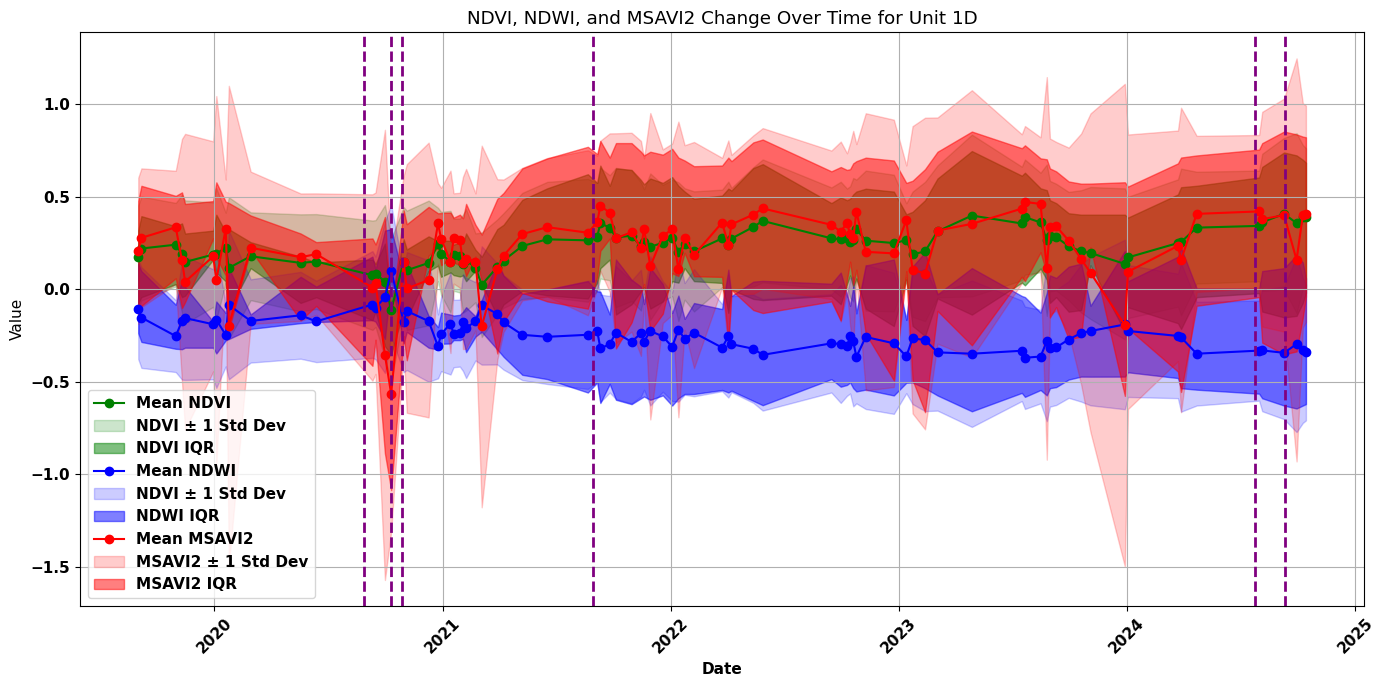

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

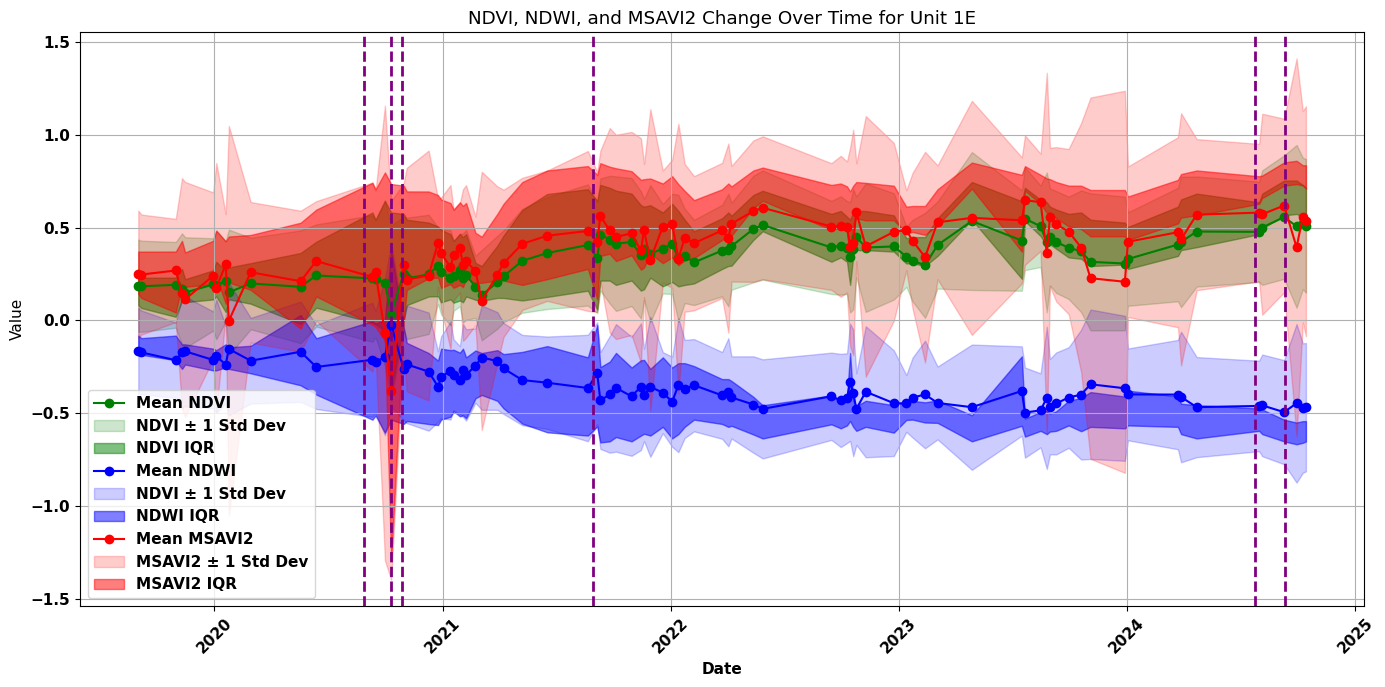

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

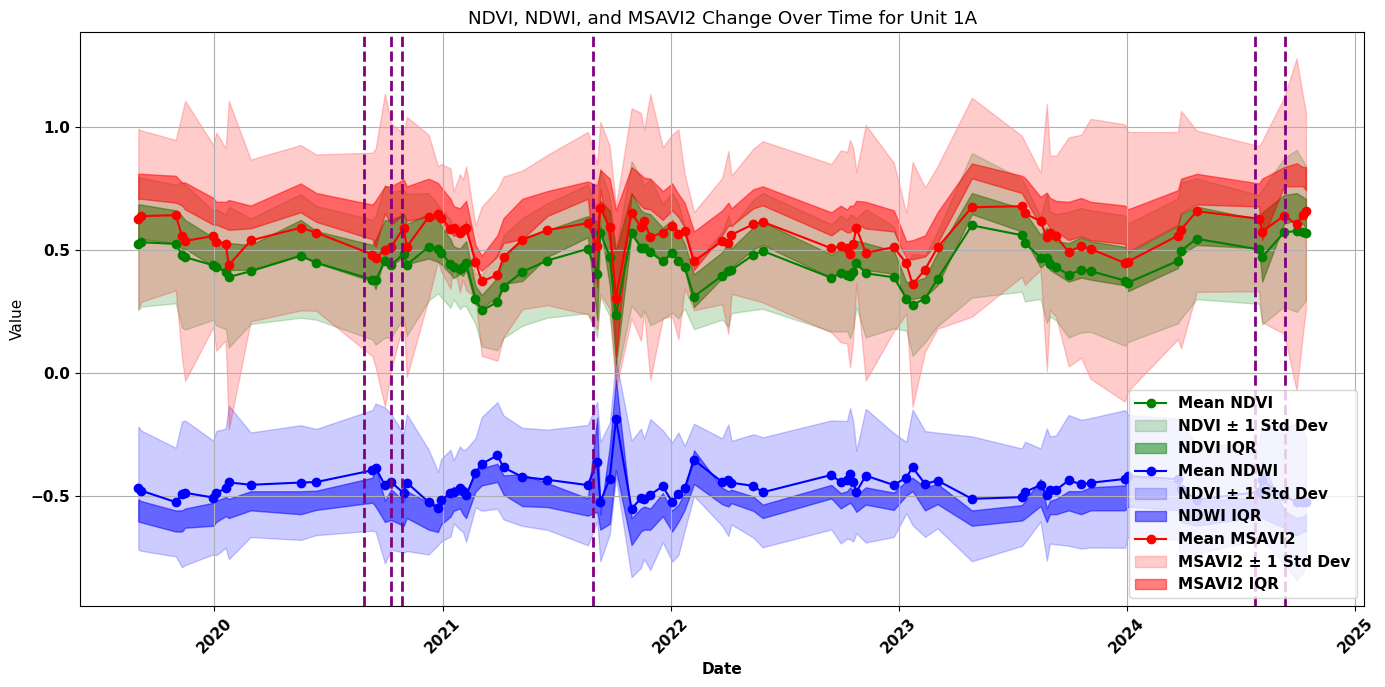

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

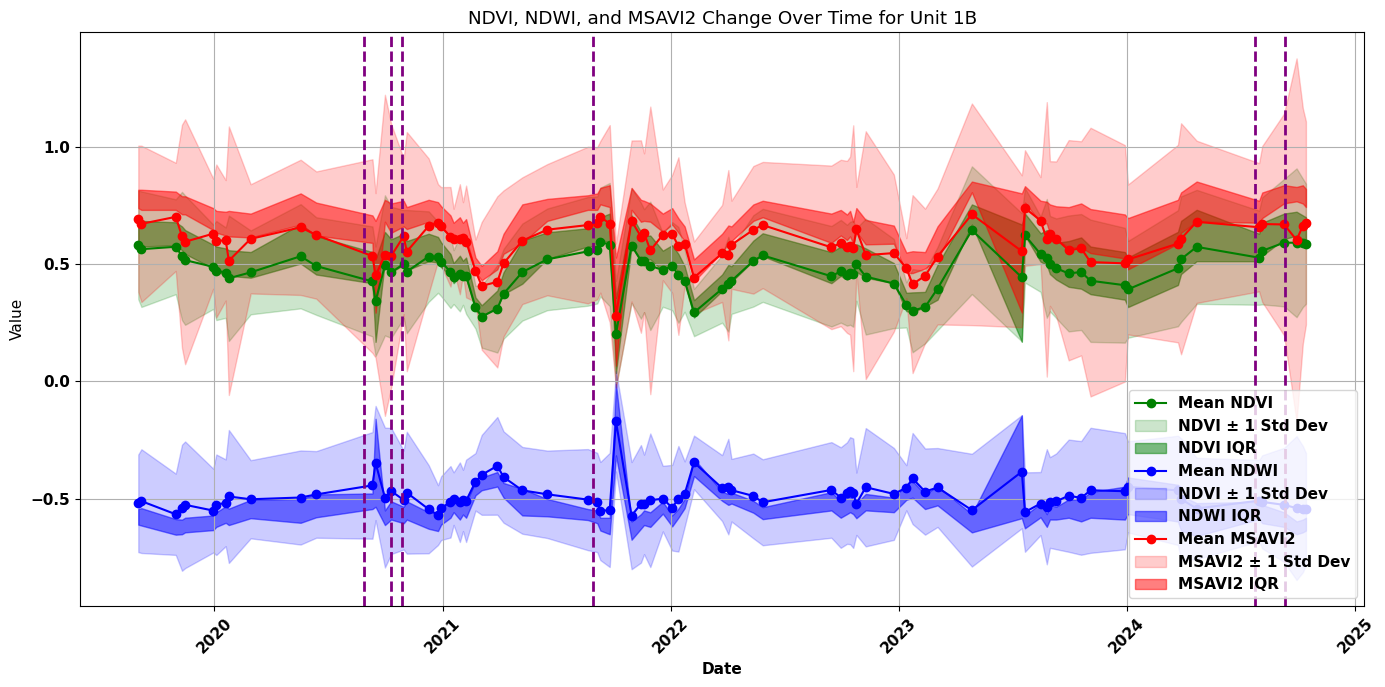

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

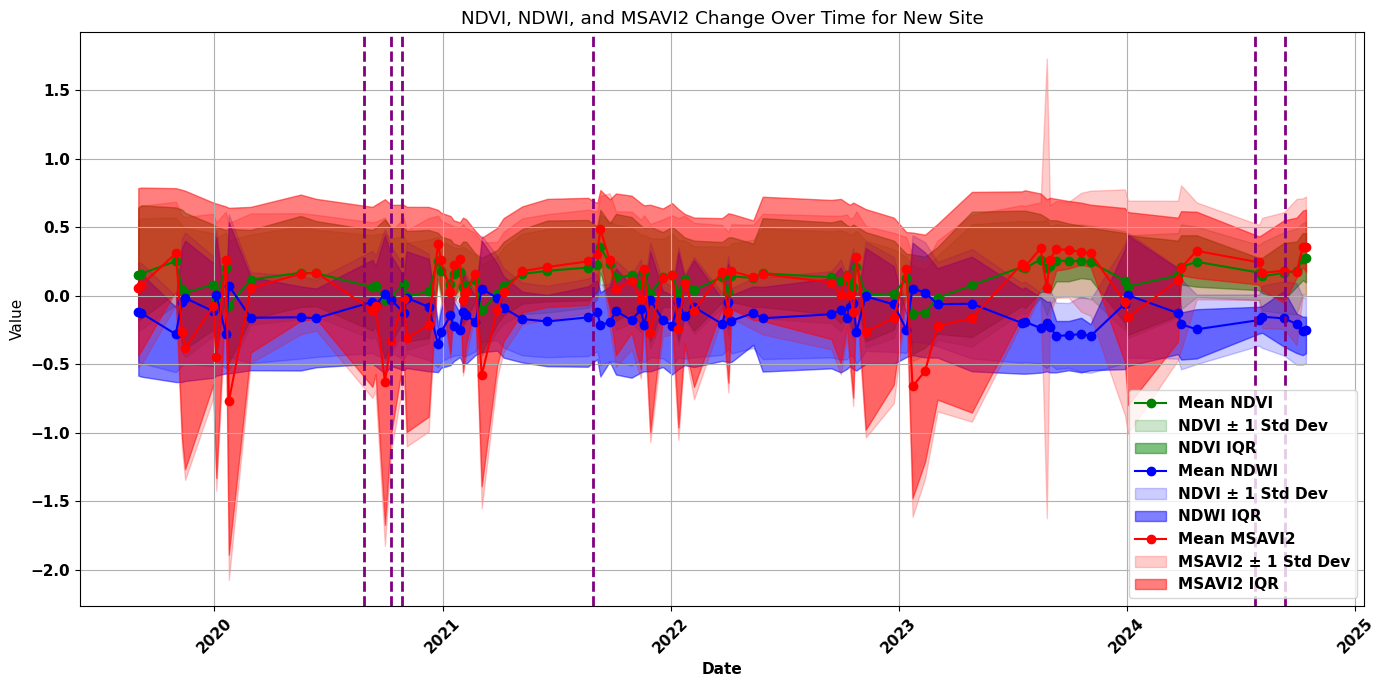

In [33]:
plot_VI_ts(sites['Site 0'], 'Unit 1D', 'together')
plot_VI_ts(sites['Site 1'], 'Unit 1E', 'together')
plot_VI_ts(sites['Site 2'], 'Unit 1A', 'together') # site finished in Sept 2019
plot_VI_ts(sites['Site 3'], 'Unit 1B', 'together') # site finished in Sept 2019
plot_VI_ts(sites['Site 4'], 'New Site', 'together') # site finished in Sept 2019


In [ ]:
plot_GRD_ts(sites['Site 0'], 'Unit 1D', 'together', total_colls['s1'])
# plot_GRD_ts(sites['Site 2'], 'Unit 1B', 'together', total_colls['s1'])
# plot_GRD_ts(sites['Site 0'], 'Unit 1D', 'together', total_colls['s1']) # site finished in Sept 2019
# plot_GRD_ts(sites['Site 1'], 'Unit 1E', 'together', total_colls['s1']) # site finished in Sept 2019

In [ ]:
de

# ## Time series plot to show changes in NDVI and NDWI
# plot_VI_ts_combined(sites['Site 4'], 'Unit 1A', 'together')
# plot_VI_ts_combined(sites['Site 3'], 'Unit 1B', 'together')
# plot_VI_ts_combined(sites['Site 1'], 'Unit 1D', 'together') # site finished in Sept 2019
# plot_VI_ts_combined(sites['Site 2'], 'Unit 1E', 'together') # site finished in Sept 2019
# plot_VI_ts_combined(sites['Site 0'], '2023 Site', 'together') #Site Created in late 2023


# plot_VI_ts_combined(sites['Site 9'], 'Cycle 1', 'together')
# plot_VI_ts_combined(sites['Site 6'], 'Cycle 2', 'together')
# plot_VI_ts_combined(sites['Site 5'], 'Cycle 3', 'together') 
# plot_VI_ts_combined(sites['Site 7'], 'Cycle 4', 'together') 
# plot_VI_ts_combined(sites['Site 8'], 'Cycle 5', 'together') 

- Mean NDVI/NDWI Above Q3: small proportion of higher values pulling the mean upwards—perhaps due to localized greening or a recent vegetation growth spurt affecting only part of the area.
- Mean NDVI/NDWI Below Q1: extreme low values are present, pulling the mean down—potentially due to vegetation loss, seasonal dry periods, or land cover change in part of the region.

# Extract time series of Land Area Change (m2) for the marsh creation sites defined above

In [306]:
land_area_lists = []
dates_lists = []

for idx, site_name in enumerate(sites):
    land_images = extract_land(
    masked_pairs[site_name][0], 
    masked_pairs[site_name][1].select(['NDWI']),
    masked_pairs[site_name][1].select(['NDVI'])
)

    land_area_images = land_images.map(lambda img: img.clip(sites[f'Site {idx}'])).map(calculate_land_area)
    land_area_list = land_area_images.aggregate_array('total_land_area').getInfo()
    dates_list = land_area_images.aggregate_array('system:time_start').getInfo()
    land_area_lists.append(land_area_list)
    dates_lists.append(dates_list)

# Convert the UNIX timestamps to readable dates using the first site's dates as a reference
dates = [datetime.utcfromtimestamp(date / 1000).strftime('%Y-%m-%d') for date in dates_lists[0]]
df_data = {'Date': pd.to_datetime(dates)}  # Convert to datetime format

# Add land area for each site to the dataframe
for idx, site_name in enumerate(sites):
    df_data[f'Land Area (sq km), {site_name}'] = land_area_lists[idx]

    df = pd.DataFrame(df_data)

# Correct storm dates in 'YYYYMMDD' format and convert to datetime
storm_dates = {
    'Hurricane Laura': datetime.strptime('2020-08-27', '%Y-%m-%d'),
    'Hurricane Delta': datetime.strptime('2020-10-09', '%Y-%m-%d'),
    'Hurricane Zeta': datetime.strptime('2020-10-28', '%Y-%m-%d'),
    'Hurricane Ida': datetime.strptime('2021-08-29', '%Y-%m-%d'),
    'Hurricane Beryl': datetime.strptime('2024-07-24', '%Y-%m-%d'),
    'Hurricane Francine': datetime.strptime('2024-09-14', '%Y-%m-%d')
}

# Define specific colors for each storm
storm_colors = {
    'Hurricane Laura': '#1f77b4',  # Dark Blue
    'Hurricane Delta': '#2ca02c',  # Dark Green
    'Hurricane Zeta': '#d62728',   # Dark Red
    'Hurricane Ida': '#ff7f0e',    # Dark Orange
    'Hurricane Beryl': '#9467bd',  # Purple
    'Hurricane Francine': '#000000'  # Black
}

# Plotting the land area over time for each site
plt.figure(figsize=(30, 6), dpi = 1000)

for idx, site_name in enumerate(sites):
    if site_name == 'Site 0':
        plt.plot(df['Date'], df[f'Land Area (sq km), {site_name}'], marker='o', label=f'Land Area, Unit 1D') #label=f'Land Area, Unit 1D'
    elif site_name == 'Site 1':
        plt.plot(df['Date'], df[f'Land Area (sq km), {site_name}'], marker='o', label=f'Land Area, Unit 1E')     
    elif site_name == 'Site 2':
        plt.plot(df['Date'], df[f'Land Area (sq km), {site_name}'], marker='o', label=f'Land Area, Unit 1A')
    elif site_name == 'Site 3':
        plt.plot(df['Date'], df[f'Land Area (sq km), {site_name}'], marker='o', label=f'Land Area, Unit 1B')
    elif site_name == 'Site 4':
        plt.plot(df['Date'], df[f'Land Area (sq km), {site_name}'], marker='o', label=f'Land Area,New Site') 

# Adding hurricane event lines
for storm, date in storm_dates.items():
    plt.axvline(x=date, color=storm_colors[storm], linestyle='--', linewidth=1.5, label=f'{storm}') #, label=f'{storm}}'

# Labels and formatting
plt.xlabel('Date', fontweight = 'bold', fontsize = 14)
plt.ylabel('Land Area (sq km)', fontweight = 'bold', fontsize = 14)
plt.title(f'Land Area Changes Over Time for Unit 1D', fontweight = 'bold', fontsize = 16)
plt.xticks(rotation=45, fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.grid(True)
# plt.legend(loc='upper left', fontsize='large')

# Show plot
plt.tight_layout()
plt.show()